In [1]:
# https://bigquery.cloud.google.com/dataset/the-psf:pypi

%matplotlib inline

import os
import io
import json
import functools

import pandas as pd
import pandas_gbq  # pip install "pandas-gbq>=0.2"

CRED_KW = {'token', 'refresh_token', 'id_token', 'token_uri', 'client_id', 'client_secret'}

PROJECT_ID = 'scripting-148608'

def load_credentials(filename, scopes):
    from google.oauth2.credentials import Credentials
    if os.path.exists(filename):
        with io.open(filename, 'rb') as f:
            kwargs = json.load(f)
        kwargs['token'] = kwargs.pop('access_token')
        kwargs = {k: v for k, v in kwargs.items() if k in CRED_KW}
        return Credentials(**kwargs, scopes=scopes)

def save_credentials(creds, filename):
    doc = {k: getattr(creds, k) for k in (CRED_KW - {'token'})}
    doc['access_token'] = creds.token
    with io.open(filename, 'w') as f:
        json.dump(doc, f)
    
def get_credentials(scopes, secrets='~/client_secrets.json', storage='~/storage.json'):
    creds = load_credentials(os.path.expanduser(storage), scopes)
    if creds is None:
        from google_auth_oauthlib.flow import InstalledAppFlow
        flow = InstalledAppFlow.from_client_secrets_file(os.path.expanduser(secrets), scopes)
        flow.run_local_server()
        creds = flow.credentials
        save_credentials(creds, os.path.expanduser(storage))
    return creds

class GbqConnector(pandas_gbq.gbq.GbqConnector):

    def get_user_account_credentials(self):
        return get_credentials(self.scope)

pandas_gbq.gbq.GbqConnector = GbqConnector  # monkey patch

read_gbq = functools.partial(pd.io.gbq.read_gbq, dialect='standard', project_id=PROJECT_ID)

In [2]:
RESULT, START, END = 'pypi.csv', '20160601', '20171231'

PROJECTS = (
    'graphviz', 'features', 'concepts', 'bitsets', 'fileconfig',
    'gsheets', 'latexpages', 'dmengine', 'current',
)

QUERY ='''SELECT
  EXTRACT(YEAR FROM timestamp) AS year, EXTRACT(MONTH FROM timestamp) AS month,
  file.project AS project, file.version AS version, file.type AS type,
  country_code AS country,
  REGEXP_EXTRACT(details.python, r'^([^\.]+\.[^\.]+)') AS python,
  details.system.name AS system,
  COUNT(*) AS downloads
FROM `the-psf.pypi.downloads*`
WHERE _TABLE_SUFFIX BETWEEN '%s' AND '%s' AND file.project IN %r
GROUP BY year, month, project, version, type, country, python, system''' % (START, END, PROJECTS)

if not os.path.exists(RESULT):
    _df = read_gbq(QUERY)
    _df.to_csv(RESULT, index=False, encoding='utf-8')

INDEX = ['year', 'month', 'project', 'version', 'type', 'country', 'python', 'system']
ASC = [i not in ('year', 'month') for i in INDEX]
    
_df = pd.read_csv(RESULT, encoding='utf-8')\
    .sort_values(by=INDEX, ascending=ASC).reset_index(drop=True)
_df.info()

Requesting query... ok.
Job ID: job_Vg7NEdFR5pShYg46IxB6RUj3kilW
Query running...
  Elapsed 13.85 s. Waiting...
  Elapsed 24.3 s. Waiting...
  Elapsed 34.79 s. Waiting...
  Elapsed 45.26 s. Waiting...
  Elapsed 55.74 s. Waiting...
Query done.
Processed: 588.0 GB
Standard price: $2.87 USD

Retrieving results...
  Got page: 1; 36% done. Elapsed 66.24 s.
  Got page: 2; 72% done. Elapsed 71.23 s.
  Got page: 3; 100% done. Elapsed 75.75 s.
Got 107735 rows.

Total time taken 78.5 s.
Finished at 2018-01-02 11:43:25.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107735 entries, 0 to 107734
Data columns (total 9 columns):
year         107735 non-null int64
month        107735 non-null int64
project      107735 non-null object
version      107735 non-null object
type         107735 non-null object
country      102126 non-null object
python       36747 non-null float64
system       32972 non-null object
downloads    107735 non-null int64
dtypes: float64(1), int64(3), object(5)
memory usage: 7

In [3]:
df = _df.fillna('N/A')
df.head()

,year,month,project,version,type,country,python,system,downloads
0,2017,12,bitsets,0.1,sdist,AU,N/A,N/A,2
1,2017,12,bitsets,0.1,sdist,CA,N/A,N/A,2
2,2017,12,bitsets,0.1,sdist,CN,N/A,N/A,12
3,2017,12,bitsets,0.1,sdist,DE,N/A,N/A,3
4,2017,12,bitsets,0.1,sdist,EU,N/A,N/A,1


In [4]:
df.pivot_table('downloads', ['year', 'month'], 'project', aggfunc='sum', fill_value=0)

project     bitsets  concepts  current  dmengine  features  fileconfig  \
year month                                                               
2016 6         3805      3799      654      1244      2286        1360   
     7         3905      3999      974      1413      2407        1532   
     8         4494      4505     1099      1737      2790        1751   
     9         3989      4158     1169      1658      2559        1636   
     10        3156      3002      776      1159      1912        1227   
     11        3376      3505      622      1133      2040        1188   
     12        2811      2873      505       931      1698        1011   
2017 1         3145      3099      532       866      1571         940   
     2         2981      3072      568      1005      1760        1077   
     3         3649      3889      675      1162      2063        1202   
     4         4387      4434      850       793      2544        1510   
     5         2946      2632     1140      1326      2470        2810   
     6         3001      2911      798      1014      1872        1661   
     7         2492      2353      653       874      1646        1328   
     8         2433      2415      574      1428      1558        1115   
     9         2431      2247      570       987      1619        1205   
     10        3163      3257      524       936      2282        1998   
     11        3305      3028      517       978      2394        1924   
     12        2985      3037      670      1192      2208        1776   

project     graphviz  gsheets  latexpages  
year month                                 
2016 6         23462        0        2327  
     7         27466        0        2175  
     8         27825        0        2459  
     9         34277        0        4306  
     10        31108        0        1843  
     11        32904      526        1971  
     12        36357      278        1703  
2017 1         47077      198        1464  
     2         47283      226        1854  
     3         59031      967        3395  
     4         55757      389        1699  
     5         60170      268        1351  
     6         64933      358        1637  
     7         95162      491        1409  
     8        118609     1465        1497  
     9        107230      608        1659  
     10       125717     1351        2251  
     11       112268     3925        1794  
     12       122657      617        2170

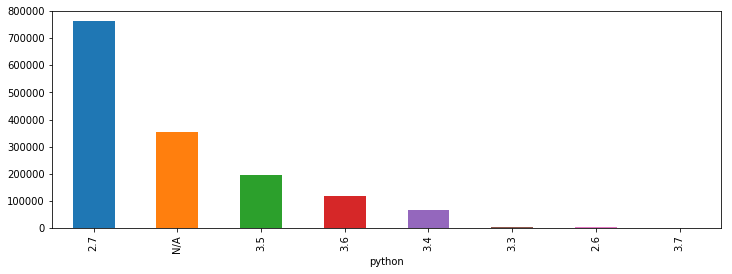

In [5]:
df.groupby('python')['downloads'].sum()\
    .sort_values(ascending=False)[:8].plot.bar(figsize=(12, 4));

In [6]:
df.groupby('python')['downloads'].sum()\
    .sort_values(ascending=False).to_frame()\
    .apply(lambda x: x / x.sum()).style.format('{:.2%}').set_uuid('6')

,downloads
python,
2.7,50.63%
N/A,23.55%
3.5,12.87%
3.6,7.85%
3.4,4.48%
3.3,0.29%
2.6,0.21%
3.7,0.08%
1.17,0.03%


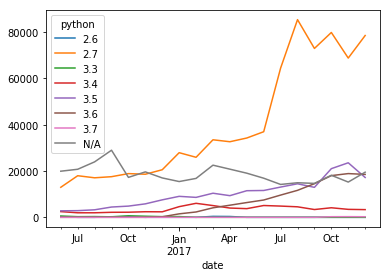

In [7]:
df.groupby(['year', 'month', 'python']).sum()\
    [lambda x: x['downloads'] > 200].reset_index()\
    .assign(date=lambda x: pd.to_datetime(x[['year', 'month']].assign(day=1)))\
    .pivot(index='date', columns='python', values='downloads').fillna(0, downcast='infer')\
    .plot();

In [8]:
gf = df[df['project'] == 'graphviz'].drop('project', axis=1)
gf.head()

,year,month,version,type,country,python,system,downloads
3392,2017,12,0.1,sdist,AU,N/A,N/A,1
3393,2017,12,0.1,sdist,CA,N/A,N/A,2
3394,2017,12,0.1,sdist,CN,N/A,N/A,12
3395,2017,12,0.1,sdist,DE,N/A,N/A,3
3396,2017,12,0.1,sdist,FI,N/A,N/A,2


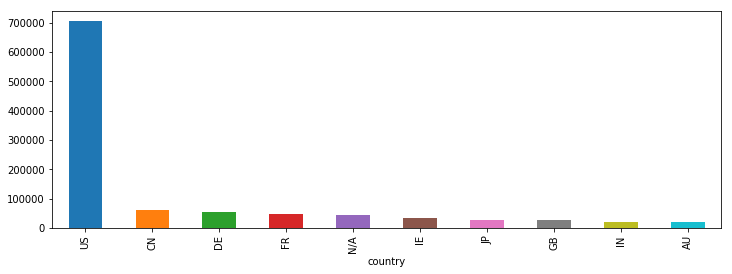

In [9]:
gf.groupby('country')['downloads'].sum().sort_values(ascending=False)[:10].plot.bar(figsize=(12, 4));

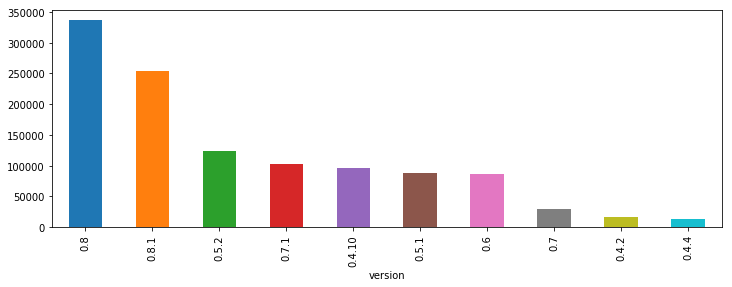

In [10]:
gf.groupby('version')['downloads'].sum().sort_values(ascending=False)[:10].plot.bar(figsize=(12, 4));

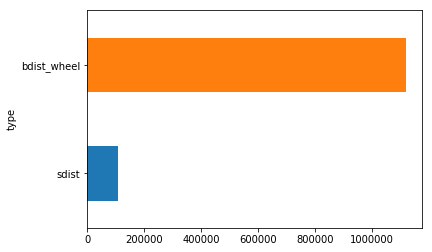

In [11]:
gf.groupby('type')['downloads'].sum().sort_values().plot.barh();

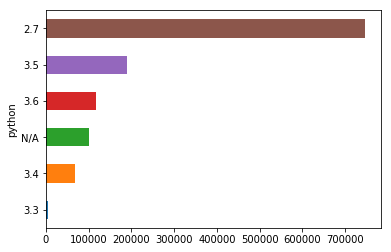

In [12]:
gf.groupby('python')['downloads'].sum().sort_values()[-6:].plot.barh();

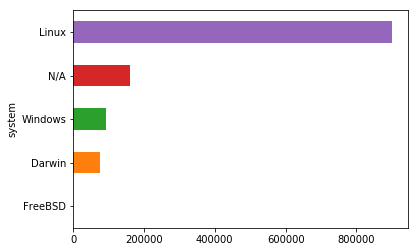

In [13]:
gf.groupby('system')['downloads'].sum().sort_values()[-5:].plot.barh();